# Objective 

* To prepare a model that can summarize and classify a passage -> mediacal paper into 5 sections
* Sections include ->
 * BACKGROUND
 * OBJECTIVE
 * METHODS
 * RESULTS
 * CONCLUSION


# Skim Lit Inputs and Outputs
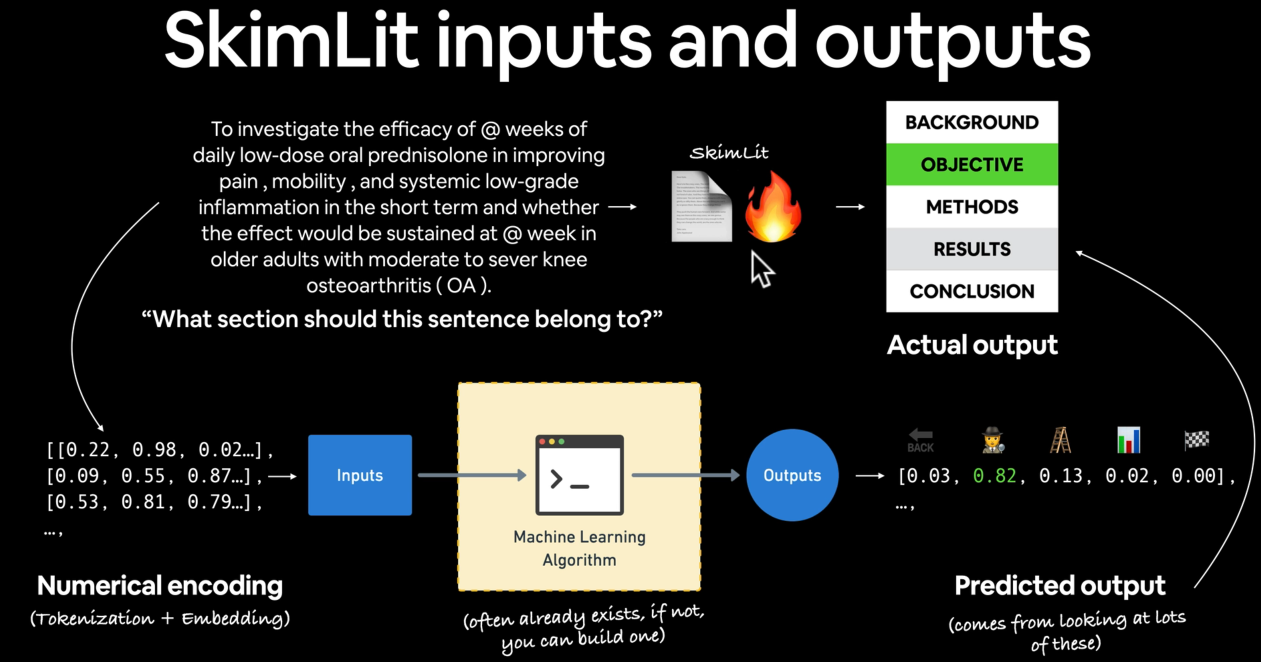


# Getting the data from Github


In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (30/30), done.


## Info about the Dataset


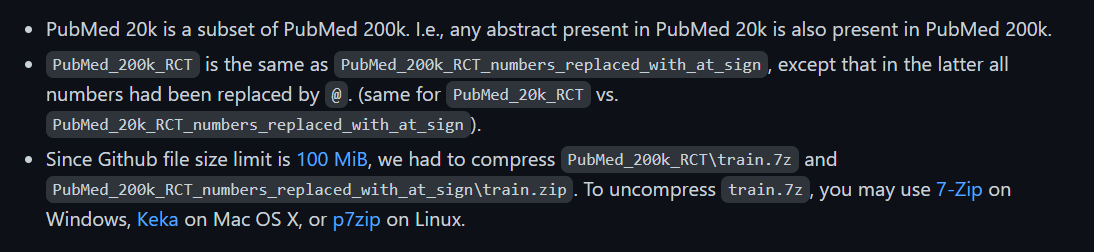

## Abstract
* PubMed 200k RCT is new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion
* From an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6713d831-72d0-9681-f218-72d92a81c85a)


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_200k_RCT
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.7z
dev.txt  test.txt  train.zip


In [5]:
!ls pubmed-rct/PubMed_20k_RCT
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [6]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [7]:
import os
os.listdir(data_dir)

['train.txt', 'test.txt', 'dev.txt']

In [8]:
filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Function: Import helper function

In [9]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-05-26 10:10:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-26 10:10:44 (92.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Preprocess the data -> Prepare the data for modelling

* The data is split into train, test and dev sets
* Stored in .txt text files

## Function: Read lines of a document

In [10]:
def get_lines(filename):
  """
  Reads from the filename and returns the lines of the text file as a list

  Returns:
      A list of strings with one string per line from the target filename

  """

  with open(filename,'r') as f:
    return f.readlines()

In [11]:
# data_dir = pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
train_lines = get_lines(data_dir+"train.txt")
train_lines[:3]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n']

In [12]:
for i in range(13):
  print(train_lines[i])

###24293578

OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .

METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .

METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .

METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( 

The role of each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).

Different abstracts are separated by abstract ID's (lines beginning with ###) and newlines (\n).

## Function: Preprocess Text File to dictionary
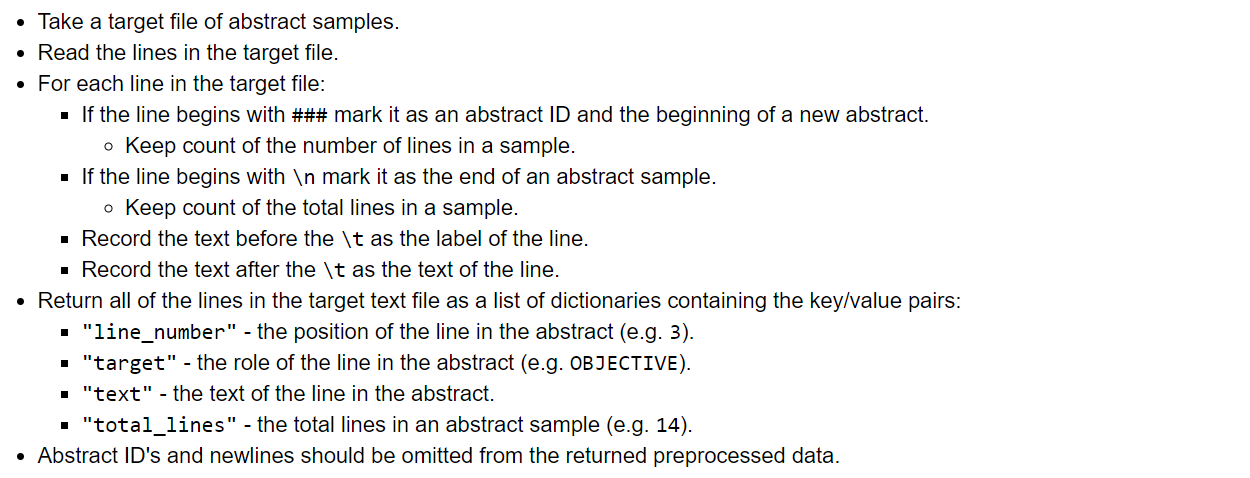

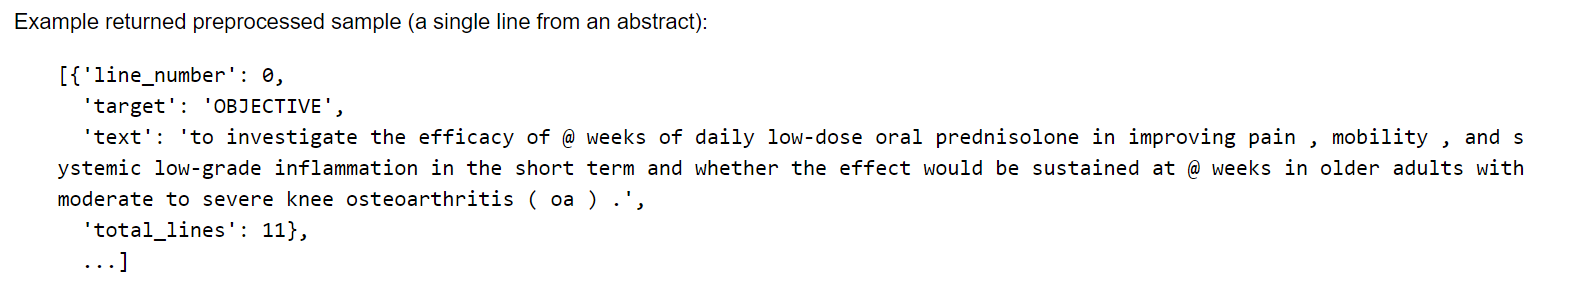

In [13]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [14]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 439 ms, sys: 95.3 ms, total: 534 ms
Wall time: 536 ms


In [15]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [16]:
train_samples[:13]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

# To Dataframe and Data Viz

In [17]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [18]:
train_df.target.value_counts()


METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [19]:
train_df.target.value_counts(normalize = True)


METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: target, dtype: float64

In [20]:
print(train_df.isnull().sum(),'\n'),
print(val_df.isnull().sum(),'\n'),
print(test_df.isnull().sum())

target         0
text           0
line_number    0
total_lines    0
dtype: int64 

target         0
text           0
line_number    0
total_lines    0
dtype: int64 

target         0
text           0
line_number    0
total_lines    0
dtype: int64


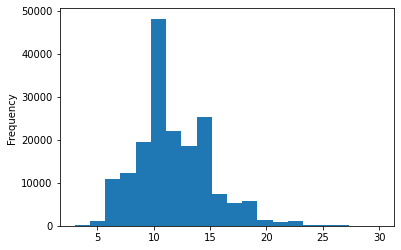

In [21]:
train_df.total_lines.plot.hist(bins = 20);


* As we can see most entries have total line count between 7-15

In [22]:
train_df['text'].tolist()[:4]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .']

In [23]:
train_df['text'].to_numpy()[:4]

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       'pain was assessed using the visual analog pain scale ( @-@ mm ) .'],
      dtype=object)

## Lists of sentences

In [24]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [25]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

##Text to Numbers

* create one hot and label encoded labels.

* just making label encoded labels would suffice, however, TensorFlow's CategoricalCrossentropy loss function prefers one hot encoded labels

### One Hot Encoder

In [26]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)


In [27]:
train_df['target'].to_numpy()[:5]

array(['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'METHODS'],
      dtype=object)

In [28]:
train_df['target'].to_numpy().reshape(-1,1)[:5]

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ['METHODS'],
       ['METHODS']], dtype=object)

In [29]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

In [30]:
train_labels_one_hot.shape,val_labels_one_hot.shape, test_labels_one_hot.shape

((180040, 5), (30212, 5), (30135, 5))

In [31]:
train_labels_one_hot[:3]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [32]:
one_hot = OneHotEncoder(sparse = True)
train_labels_oneh = one_hot.fit_transform(train_df['target'].to_numpy().reshape(-1,1))


In [33]:
train_labels_oneh[:3].toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

### Label Encoder

In [34]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())

In [35]:
train_labels_encoded[:5]

array([3, 2, 2, 2, 2])

In [36]:
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [37]:
len(train_labels_encoded), len(val_labels_encoded), len(test_labels_encoded)

(180040, 30212, 30135)

In [38]:
one_hot_encoder.categories_

[array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object)]

In [39]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [40]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Series of model experiments

# Model 0 -> Baseline

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0= Pipeline([
                    ('tf-idf',TfidfVectorizer()),
                    ('clf',MultinomialNB())
])

model_0.fit(X = train_sentences,y= train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [42]:
model_0.score(train_sentences,train_labels_encoded)

0.7516829593423684

In [43]:
model_0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [44]:
model_0.score(test_sentences,test_labels_encoded)

0.716674962667994

In [45]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [46]:
from helper_functions import calculate_results

In [138]:
baseline_results =calculate_results(y_true = val_labels_encoded,
                  y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Deep Models

* we need to create vectorization and embedding layers
* The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [49]:
# Find sentences lengths'
# How long is each sentence on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
round(avg_sent_len)


26

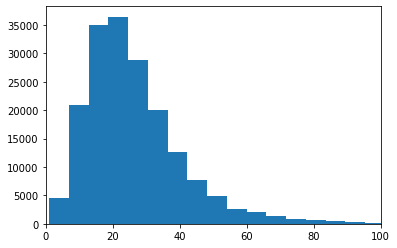

In [50]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlim(0,100)
plt.hist(sent_lens,bins = 50);

the vast majority of sentences are between 0 and 50 tokens in length

In [51]:
# Calculate 95 percentile of the sent_lens

output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

95% of the sentences in our training set have a length of 55 tokens or less.

---




We'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

### TextVectorizer -> Keras Layer

> Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [52]:
max_tokens = 68000

In [53]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,  #68000
                                    output_sequence_length= output_seq_len)  #55

In [54]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)


In [55]:
# Test out text vectorizer

import random

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")
print(f"\n Vectorized text seq lenght: {len(text_vectorizer([target_sentence])[0])}")

Text:
@ % confidence intervals of the least square mean ratios for darunavir and cobicistat maximum plasma concentration and area under the plasma concentration-time curve ( auc ) were all within @ % and @ % in panels @ and @ .

Length of text: 41

Vectorized text:
[[  235   890     4     2   322  4012    57  1124    11  8484     3 12751
    635   249   422     3   449   353     2   249  3515   901   802     9
     62   219     3     5 22250     3     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

 Vectorized text seq lenght: 55


In [56]:
print(text_vectorizer.get_vocabulary())

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment', 'is', 'after', 'by', 'this', 'groups', 'as', 'an', 'from', 'that', 'randomized', 'between', 'not', 'trial', 'no', 'compared', 'control', 'be', 'significant', 'intervention', 'significantly', 'n', 'months', 'than', 'we', 'vs', 'rsb', 'lsb', 'clinical', 'placebo', 'baseline', 'ci', 'two', 'during', 'weeks', 'both', 'had', 'primary', 'mean', 'are', 'using', 'participants', 'there', 'all', 'time', 'years', 'pain', 'therapy', 'who', 'mg', 'more', 'effect', 'effects', 'but', 'risk', 'difference', 'outcomes', 'total', 'care', 'rate', 'efficacy', 'received', 'associated', 'higher', 'respectively', 'days', 'analysis', 'outcome', 'use', 'one', 'week', 'women', 'may', 'randomly', 'levels', 'followup', 'will', 'increased', 'health', 'used', 'have', 'data', 'score', 'differences', 'age', 'subjects', 'lower', 'controlled', 'blood', 'day', 'children', 'ver

In [57]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [58]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

### Text Embedding

*   Vectorizer -> text to number
*   Embedding -> relationship between those numbers



As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

In [59]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = 'token_embedding')

print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization :\n {vectorized_sentence}")
print(f"\nVectorized list length: {len(vectorized_sentence[0])}\n\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 @ % confidence intervals of the least square mean ratios for darunavir and cobicistat maximum plasma concentration and area under the plasma concentration-time curve ( auc ) were all within @ % and @ % in panels @ and @ .

Sentence after vectorization :
 [[  235   890     4     2   322  4012    57  1124    11  8484     3 12751
    635   249   422     3   449   353     2   249  3515   901   802     9
     62   219     3     5 22250     3     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Vectorized list length: 55


Sentence after embedding:
[[[ 4.62159514e-05 -4.15935889e-02  1.06051341e-02 ... -6.85300678e-03
    1.56960003e-02 -4.40805331e-02]
  [-7.98843801e-04  3.50334756e-02 -5.54555655e-03 ... -1.70320384e-02
   -1.55324228e-02  1.20052695e-02]
  [-2.93318182e-03  1.40408538e-02  1.78523548e-02 ... -1.80242881e-02
    3.27871703e-02  4.25778143

### Creating Datasets
* The tf.data API provides methods which enable faster data loading.

In [60]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [61]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
tets_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

# Model 1: Conv1D with token embeddings

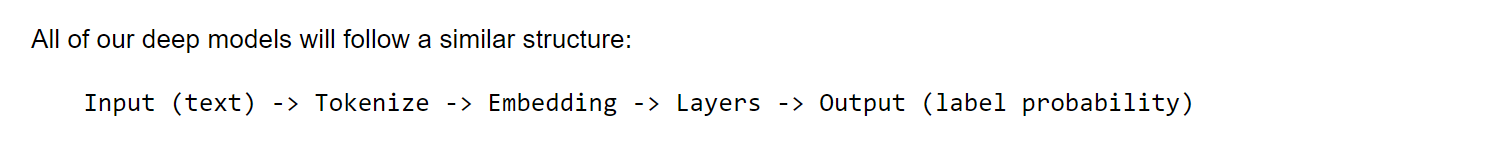

In [62]:
# Create basic 1D cnn model to process sequences

inputs = layers.Input(shape=(1,),dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size = 5, padding = 'same',activation = 'relu')(token_embeddings)
x =layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(num_classes,activation = 'softmax')(x)

model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

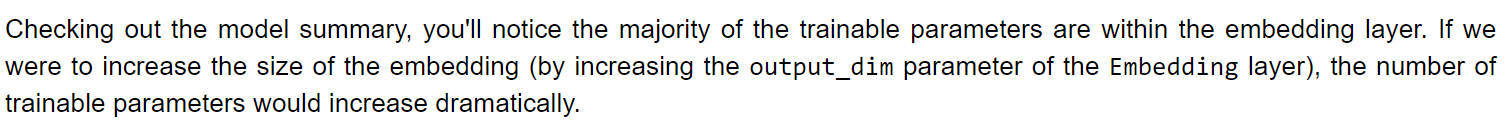

> We'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

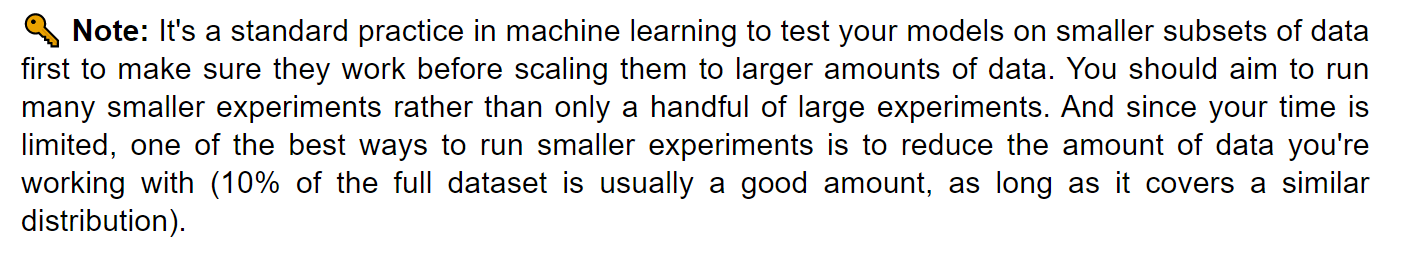

In [64]:
model_1.fit(train_dataset,
            steps_per_epoch = int(0.1*len(train_dataset)),
            validation_data = valid_dataset,
            validation_steps = int(0.15*len(valid_dataset)),
            epochs = 3, batch_size = 32)

Epoch 1/3
562/562 [==============================] - 77s 81ms/step - loss: 0.9191 - accuracy: 0.6346 - val_loss: 0.6792 - val_accuracy: 0.7345
Epoch 2/3
562/562 [==============================] - 45s 81ms/step - loss: 0.6612 - accuracy: 0.7529 - val_loss: 0.6241 - val_accuracy: 0.7677
Epoch 3/3
562/562 [==============================] - 45s 81ms/step - loss: 0.6183 - accuracy: 0.7729 - val_loss: 0.5815 - val_accuracy: 0.7877


In [65]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.1826767e-01, 1.8257937e-01, 7.0442535e-02, 2.9552692e-01,
        3.3183552e-02],
       [4.3904021e-01, 2.8278819e-01, 1.1533143e-02, 2.5820357e-01,
        8.4349802e-03],
       [1.9738586e-01, 6.9445684e-03, 2.1125826e-03, 7.9351652e-01,
        4.0496012e-05],
       ...,
       [7.0041729e-06, 9.7393256e-04, 8.6654839e-04, 3.9457323e-06,
        9.9814856e-01],
       [5.3610809e-02, 5.2936000e-01, 6.8704575e-02, 6.2213477e-02,
        2.8611115e-01],
       [1.7354897e-01, 6.6662449e-01, 6.4137131e-02, 4.7072690e-02,
        4.8616637e-02]], dtype=float32)

In [66]:
model_1_preds = tf.argmax(model_1_pred_probs,axis =1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [139]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_1_preds.numpy())
model_1_results

{'accuracy': 78.70713623725672,
 'f1': 0.7846929062159316,
 'precision': 0.7839150976248093,
 'recall': 0.7870713623725671}

# Model 2: Feature extraction with pretrained token embeddings


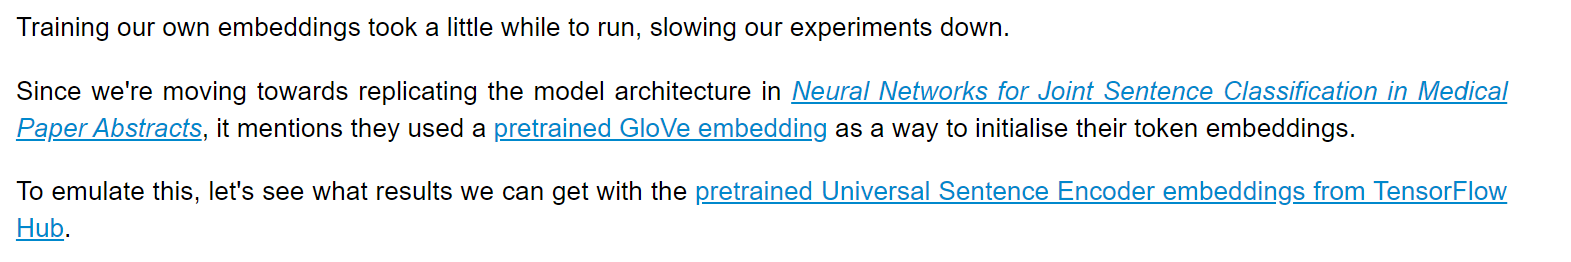

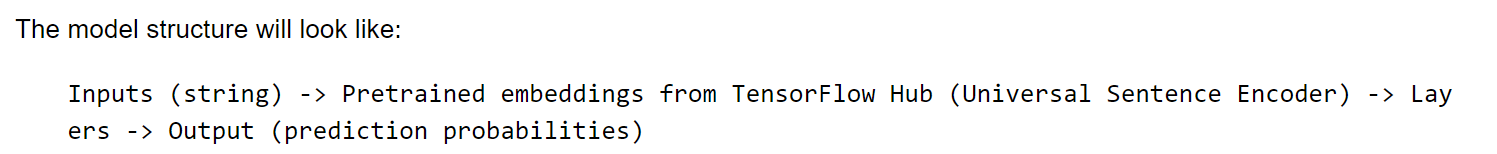

There is the lack of a tokenization layer.  This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

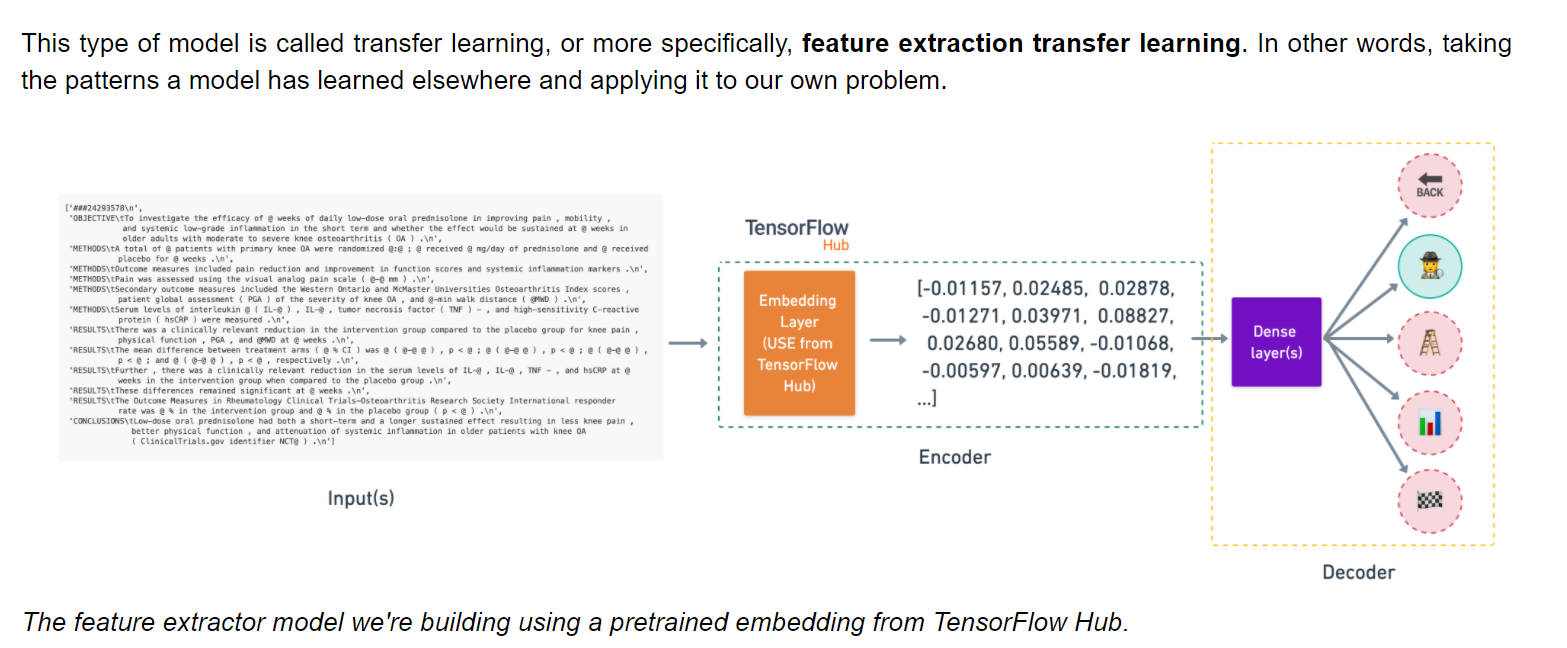

In [68]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [69]:

# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
all patients reacted moderately/severely to at least @ food ( range : @-@ ) , with a significantly greater number of food substances inducing reaction in controls compared with the `` true '' diet group ( @ vs @ , p < @ ) .

Sentence after embedding:
[ 0.00791511 -0.0501789   0.07266705  0.01796483  0.02028446 -0.007657
  0.05500923 -0.03892582  0.01567324  0.0491641   0.08451639  0.00893248
  0.07506568 -0.03093446 -0.08809454 -0.06380272 -0.05836124  0.01075936
  0.00122833  0.06012705  0.06105373  0.04335476 -0.03938545 -0.00712313
  0.03224481  0.02364356 -0.05856196  0.04034764 -0.06761248 -0.06424506] (truncated output)...

Length of sentence embedding:
512


# Model_2 -> Building and fitting an NLP feature extraction model from TensorFlow Hub

In [70]:
inputs = layers.Input(shape=[],dtype =tf.string)

pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation = 'relu') (pretrained_embedding)
x = layers.Dense(128, activation = 'relu')(x)

outputs = layers.Dense(5,activation = 'softmax')(x)

model_2 = tf.keras.Model(inputs,outputs)


# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 256,880,645
Trainable params: 82,821
Non-trainable params: 256,797,824
_________________________________________________________________


In [72]:
model_2.fit(train_dataset, 
            steps_per_epoch = int(0.1*len(train_dataset)),
            validation_data = valid_dataset,
            validation_steps = int(0.15*len(valid_dataset)),
            epochs =3)

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.8777 - accuracy: 0.6549 - val_loss: 0.7766 - val_accuracy: 0.6984
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7330 - accuracy: 0.7139 - val_loss: 0.7077 - val_accuracy: 0.7238
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7054 - accuracy: 0.7280 - val_loss: 0.6782 - val_accuracy: 0.7380


In [73]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.9201247e-01, 2.2140552e-01, 1.2089263e-03, 2.8178313e-01,
        3.5899670e-03],
       [3.6823893e-01, 4.5498690e-01, 3.5345531e-03, 1.7131007e-01,
        1.9295659e-03],
       [2.2561996e-01, 2.7430285e-02, 1.3636356e-02, 7.2381830e-01,
        9.4951671e-03],
       ...,
       [1.5134573e-03, 3.0725088e-03, 7.9992093e-02, 7.0404954e-04,
        9.1471791e-01],
       [3.1821805e-03, 3.8435698e-02, 2.4269648e-01, 1.6376276e-03,
        7.1404797e-01],
       [3.4442624e-01, 5.6372315e-01, 7.8221597e-02, 5.4588099e-03,
        8.1701772e-03]], dtype=float32)

In [74]:
model_2_preds = np.argmax(model_2_pred_probs,axis =1)
model_2_preds

array([0, 1, 3, ..., 4, 4, 1])

In [136]:
model_2_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_2_preds)
model_2_results

{'accuracy': 73.61975374023567,
 'f1': 0.7354762633218247,
 'precision': 0.7373105544059717,
 'recall': 0.7361975374023567}

# Model 3: Conv1D with character embeddings

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.

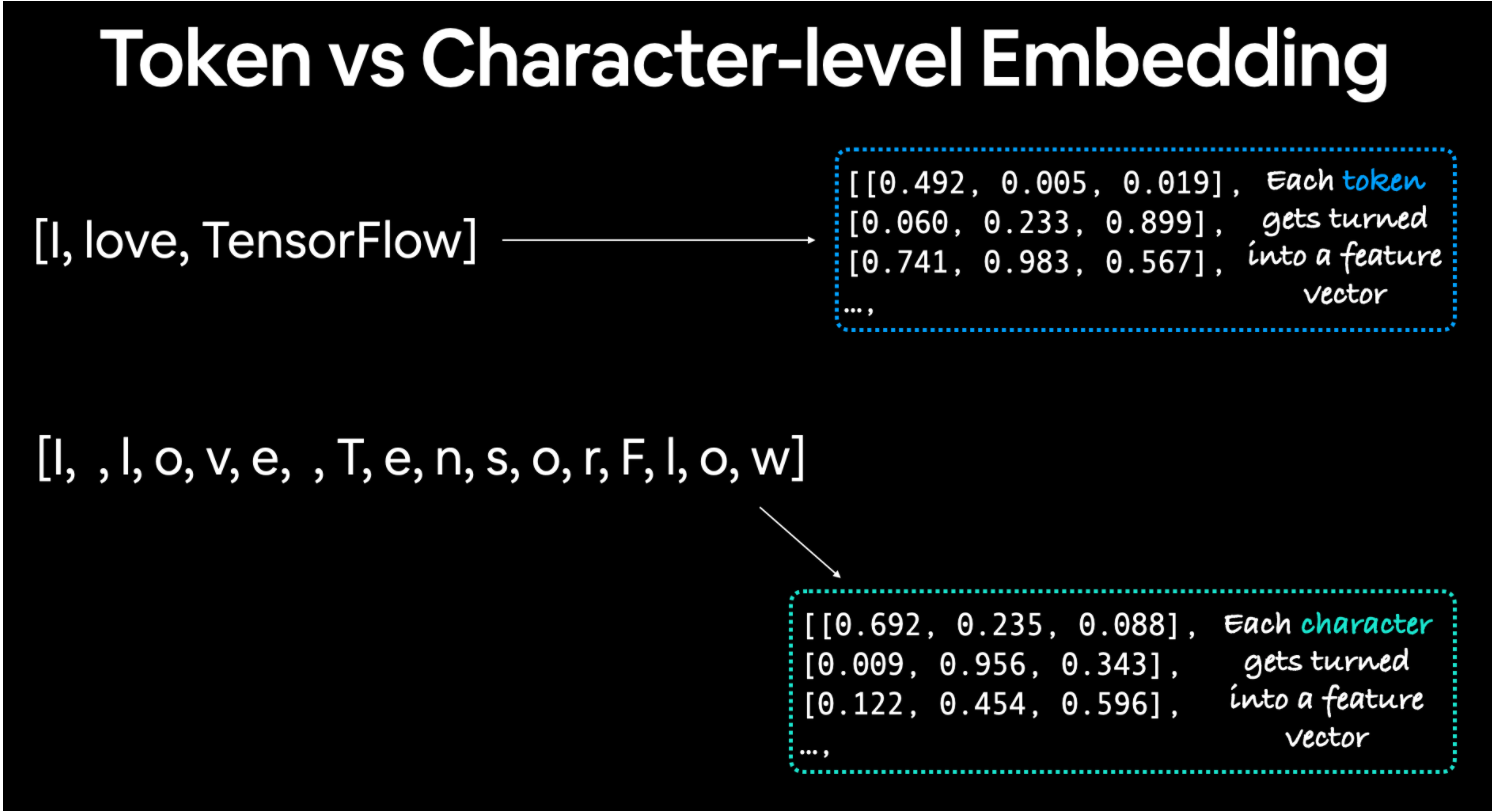

* Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.

In [76]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

"a l l   p a t i e n t s   r e a c t e d   m o d e r a t e l y / s e v e r e l y   t o   a t   l e a s t   @   f o o d   (   r a n g e   :   @ - @   )   ,   w i t h   a   s i g n i f i c a n t l y   g r e a t e r   n u m b e r   o f   f o o d   s u b s t a n c e s   i n d u c i n g   r e a c t i o n   i n   c o n t r o l s   c o m p a r e d   w i t h   t h e   ` `   t r u e   ' '   d i e t   g r o u p   (   @   v s   @   ,   p   <   @   )   ."

In [150]:
#train_chars = map(split_chars,random_training_sentence)

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[10])

t h e   o u t c o m e   m e a s u r e s   i n   r h e u m a t o l o g y   c l i n i c a l   t r i a l s - o s t e o a r t h r i t i s   r e s e a r c h   s o c i e t y   i n t e r n a t i o n a l   r e s p o n d e r   r a t e   w a s   @   %   i n   t h e   i n t e r v e n t i o n   g r o u p   a n d   @   %   i n   t h e   p l a c e b o   g r o u p   (   p   <   @   )   .


In [78]:
len(train_chars)

180040

In [79]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

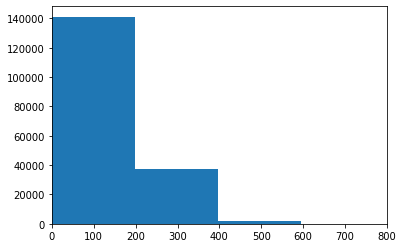

In [80]:
plt.figure()
plt.xlim(0,800)
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [81]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

> Most of our sequences are between 0 and 200 characters long.




We will set max_tokens (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [82]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [83]:

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [84]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [85]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t o   a s s e s s   t h e   e f f i c a c y   a n d   t o l e r a b i l i t y   o f   a d d - o n   p r e g a b a l i n   c o n t r o l l e d - r e l e a s e   f o r m u l a t i o n   (   p g b - c r   )   (   d o s e s   o f   @   o r   @   m g / d a y   )   i n   p a t i e n t s   w i t h   p a r t i a l - o n s e t   s e i z u r e s   (   p o s   )   .

Length of chars: 149

Vectorized chars:
[[ 3  7  5  9  9  2  9  9  3 13  2  2 17 17  4 11  5 11 19  5  6 10  3  7
  12  2  8  5 22  4 12  4  3 19  7 17  5 10 10  7  6 14  8  2 18  5 22  5
  12  4  6 11  7  6  3  8  7 12 12  2 10  8  2 12  2  5  9  2 17  7  8 15
  16 12  5  3  4  7  6 14 18 22 11  8 10  7  9  2  9  7 17  7  8 15 18 10
   5 19  4  6 14  5  3  4  2  6  3  9 20  4  3 13 14  5  8  3  4  5 12  7
   6  9  2  3  9  2  4 25 16  8  2  9 14  7  9  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Creating a character-level embedding

In [86]:
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                              output_dim = 25,
                              mask_zero = True,
                              name = 'char_embed')

In [87]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t o   a s s e s s   t h e   e f f i c a c y   a n d   t o l e r a b i l i t y   o f   a d d - o n   p r e g a b a l i n   c o n t r o l l e d - r e l e a s e   f o r m u l a t i o n   (   p g b - c r   )   (   d o s e s   o f   @   o r   @   m g / d a y   )   i n   p a t i e n t s   w i t h   p a r t i a l - o n s e t   s e i z u r e s   (   p o s   )   .

Embedded chars (after vectorization and embedding):
[[[-0.02939388  0.01624892  0.02008576 ... -0.00703872 -0.03740035
   -0.01515361]
  [ 0.03725269 -0.00442897  0.01136244 ... -0.00432069 -0.01729362
    0.0147792 ]
  [-0.03013021 -0.02011398 -0.04072434 ... -0.02300547  0.01992767
   -0.03846224]
  ...
  [-0.00831218 -0.03254095 -0.01661037 ...  0.01850135 -0.03824753
   -0.01896286]
  [-0.00831218 -0.03254095 -0.01661037 ...  0.01850135 -0.03824753
   -0.01896286]
  [-0.00831218 -0.03254095 -0.01661037 ...  0.01850135 -0.03824753
   -0.01896286]]]

Character embedding shape: (1

Each of the characters in our sequences gets turned into a 25 dimension embedding.

### Building a Conv1D model to fit on character embeddings

In [88]:
inputs = layers.Input(shape = (1,), dtype = 'string')

char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)

x = layers.Conv1D(64,kernel_size = 5,padding = 'same',activation = 'relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs,outputs,name = 'model_3_char_embedding_conv1D')

In [89]:
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])

In [90]:
model_3.summary()

Model: "model_3_char_embedding_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           1750      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 10,139
Trainable params: 10,139
Non-trainable params: 0
_________________________________

In [91]:
#Create Char level prefetched Datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [92]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs =3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2521 - accuracy: 0.4911 - val_loss: 1.0312 - val_accuracy: 0.5944
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9988 - accuracy: 0.6000 - val_loss: 0.9340 - val_accuracy: 0.6370
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9219 - accuracy: 0.6381 - val_loss: 0.8684 - val_accuracy: 0.6705


In [93]:
model_3.evaluate(val_char_dataset)


945/945 [==============================] - 4s 4ms/step - loss: 0.8903 - accuracy: 0.6554


[0.8902595043182373, 0.6553687453269958]

In [94]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.15906036, 0.43716255, 0.06785287, 0.23188263, 0.10404167],
       [0.12161011, 0.55305296, 0.0119129 , 0.2635772 , 0.04984691],
       [0.18696706, 0.26229203, 0.07434598, 0.4580562 , 0.01833873],
       ...,
       [0.01956479, 0.03416948, 0.1694278 , 0.03163319, 0.74520475],
       [0.05831786, 0.12185689, 0.29967558, 0.07762981, 0.44251984],
       [0.46922714, 0.33216515, 0.07960087, 0.11326161, 0.00574534]],
      dtype=float32)

In [95]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [96]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.53687276578842,
 'f1': 0.6478387820203158,
 'precision': 0.6555769310435355,
 'recall': 0.6553687276578842}

# Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

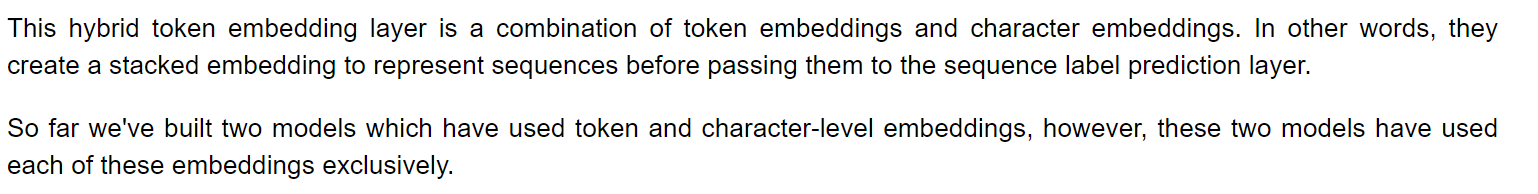

* Model similar to Figure 1 of [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf)

Steps:
> 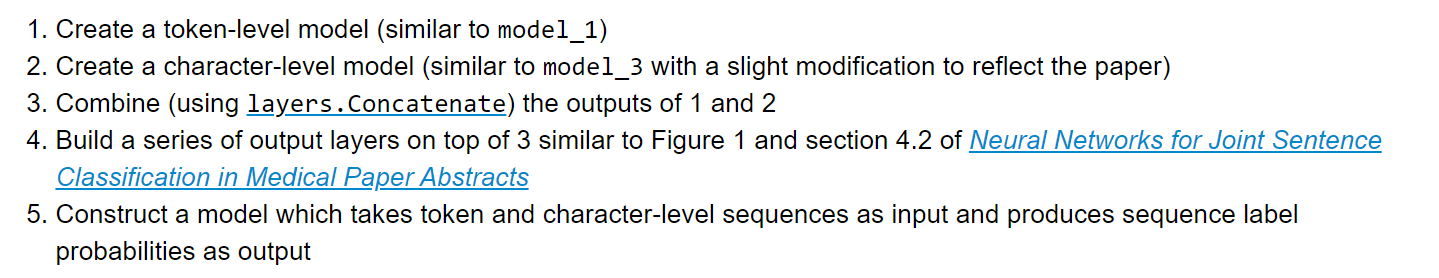

In [97]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [98]:
model_4.summary()


Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

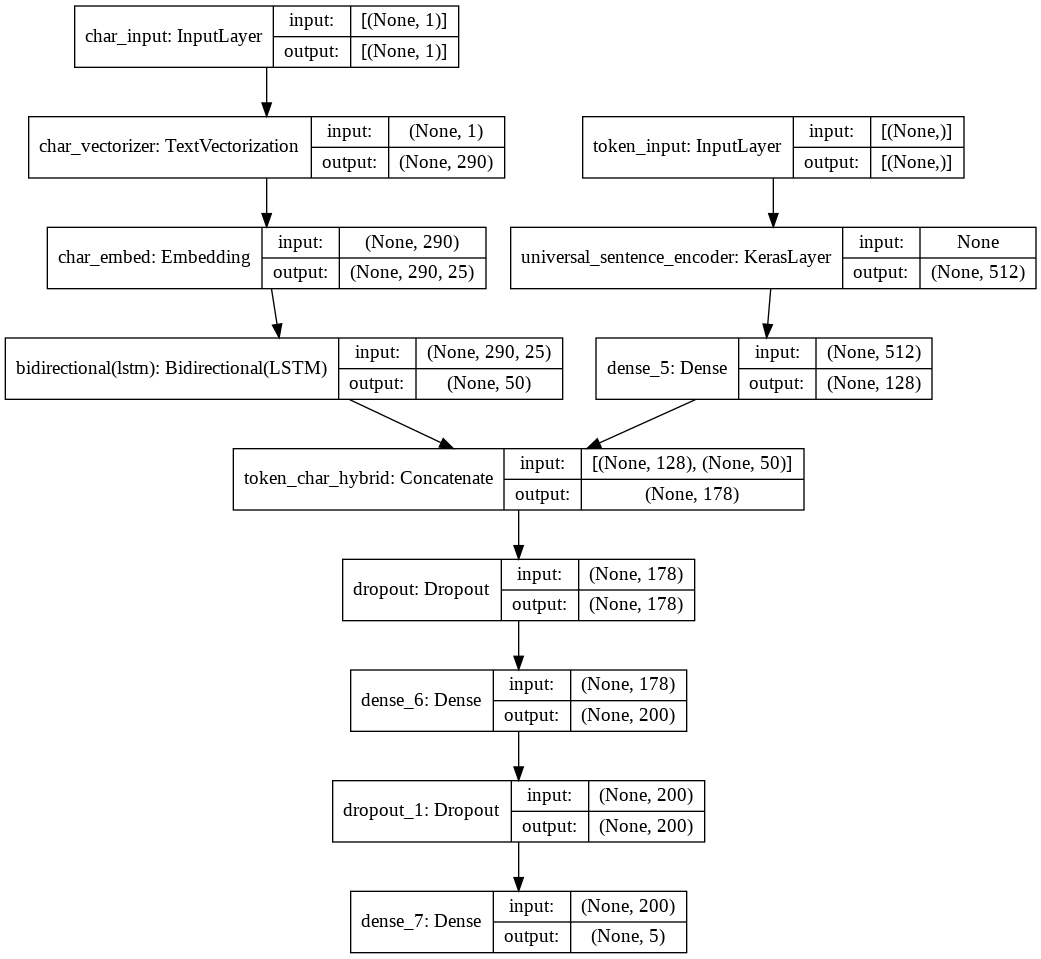

In [99]:
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [100]:

# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

> This model is that it requires two inputs, token-level sequences and character-level sequences.

> We can do this by create a tf.data.Dataset with a tuple as it's first input, for example:

> ((token_data, char_data), (label))

### Combining token and character data into a tf.data dataset

In [101]:
train_sentences[:2]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .']

In [102]:
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [103]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_label = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_label))

#Prefetch and batch
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [104]:
train_char_token_dataset, val_char_token_dataset


(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [105]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 36s 50ms/step - loss: 0.9635 - accuracy: 0.6160 - val_loss: 0.7614 - val_accuracy: 0.7064
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7854 - accuracy: 0.6958 - val_loss: 0.7094 - val_accuracy: 0.7304
Epoch 3/3
562/562 [==============================] - 23s 42ms/step - loss: 0.7646 - accuracy: 0.7046 - val_loss: 0.6860 - val_accuracy: 0.7457


In [106]:
model_4.evaluate(val_char_token_dataset)


945/945 [==============================] - 21s 22ms/step - loss: 0.6950 - accuracy: 0.7375


[0.6949930787086487, 0.7375215291976929]

In [107]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.5604786e-01, 2.9817393e-01, 3.7029500e-03, 2.3515411e-01,
        6.9211228e-03],
       [4.2074499e-01, 2.8254834e-01, 1.9173977e-03, 2.9262331e-01,
        2.1659953e-03],
       [2.7211002e-01, 8.7909259e-02, 2.1363882e-02, 5.9183156e-01,
        2.6785377e-02],
       ...,
       [7.8287162e-04, 1.0572871e-02, 6.8545170e-02, 4.0069150e-04,
        9.1969842e-01],
       [7.1211937e-03, 7.0644684e-02, 2.2713140e-01, 3.9266068e-03,
        6.9117612e-01],
       [3.1871831e-01, 3.2597792e-01, 2.7453110e-01, 3.3658385e-02,
        4.7114208e-02]], dtype=float32)

In [108]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [109]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.75215146299485,
 'f1': 0.7360107234305765,
 'precision': 0.7374211478979553,
 'recall': 0.7375215146299484}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [110]:
train_df.head()


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

## Create positional embeddings

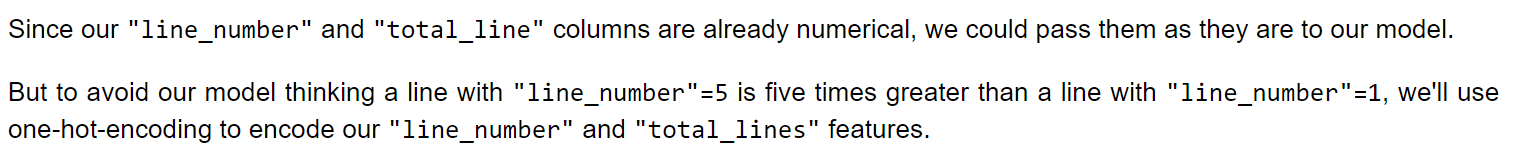

In [111]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

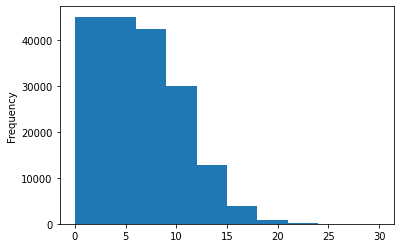

In [112]:
train_df['line_number'].plot.hist()

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less.

In [156]:
# One hot encoding the 'line_number' column

train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth = 15)

Setting the depth parameter of tf.one_hot to 15 means any sample with a "line_number" value of over 15 gets set to a tensor of all 0's, where as any sample with a "line_number" of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the "line_number" value.

In [114]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]


(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,


We can do the same as we've done for our "line_number" column witht he "total_lines" column. First, let's find an appropriate value for the depth parameter of tf.one_hot.

In [115]:
train_df["total_lines"].value_counts()


11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

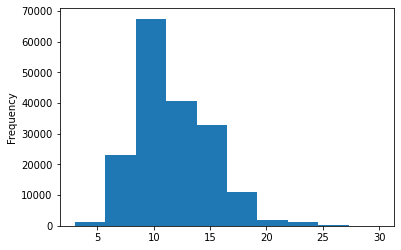

In [116]:
train_df['total_lines'].plot.hist();




Looking at the distribution of our "total_lines" column, a value of 20 looks like it covers the majority of samples.

In [117]:
np.percentile(train_df['total_lines'],98)
# Check the coverage of a "total_lines" value of 20


20.0

In [118]:
# One hot encode the 'total_lines' column

train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(),depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(),depth =20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(),depth = 20)

train_total_lines_one_hot.shape,train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [119]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

## Building a tribrid embedding model

> Model 5  incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

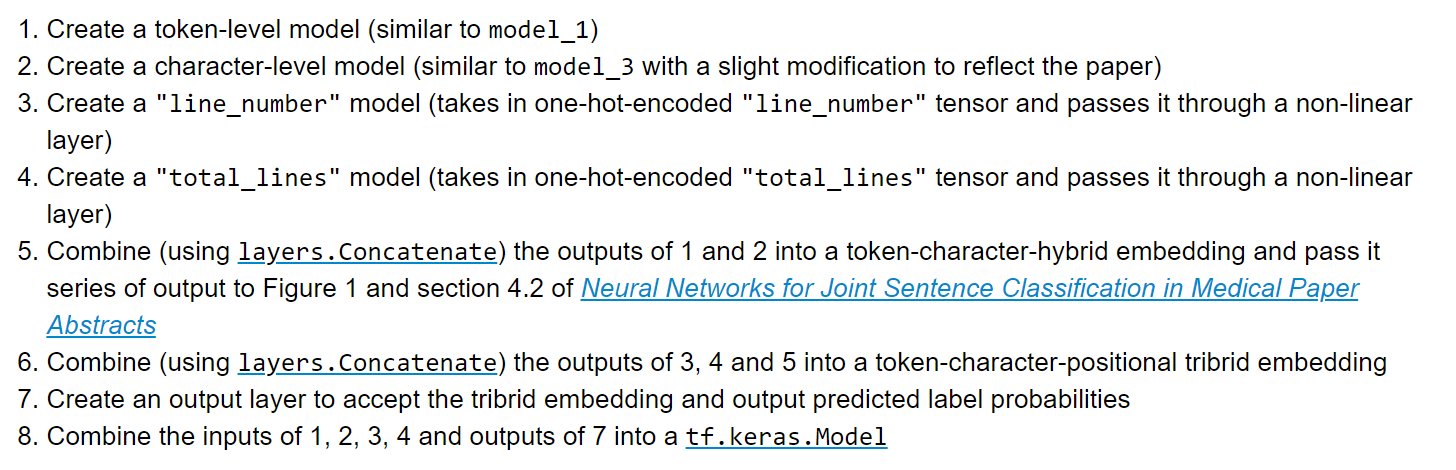

In [120]:
# 1 Token inputs
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_embeddings)

# Char inputs
char_inputs = layers.Input(shape =(1,), dtype = tf.string, name = 'char_inputs')
char_vect = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vect)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3 Line numbers inputs
line_number_inputs = layers.Input(shape = (15,),dtype = tf.int32, name = 'line_number_input')
x = layers.Dense(32,activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# 4 Total lines inputs
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.int32, name = 'total_lines_input')
y = layers.Dense(32,activation = 'relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs = y)

# 5. Combine token and char embeddings into single hybrid embedding layer
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_embedding')([token_model.output,
                                                                                char_model.output])
z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6 Combine positional m=embeddings with combined (tokens and char) into single tribrid embedding

z = layers.Concatenate(name = 'token_char_positional_embedding_tribrid')([line_number_model.output,
                                                                         total_line_model.output,
                                                                         z])

# 7. Create output layer
output_layer = layers.Dense(5,activation = 'softmax', name ='output_layer')(z)


# 8. Put together model
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_line_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer)




In [121]:
model_5.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, 290, 25)      1750        char_vectorizer[2][0]            
____________________________________________________________________________________________

## Model 5 Plot 

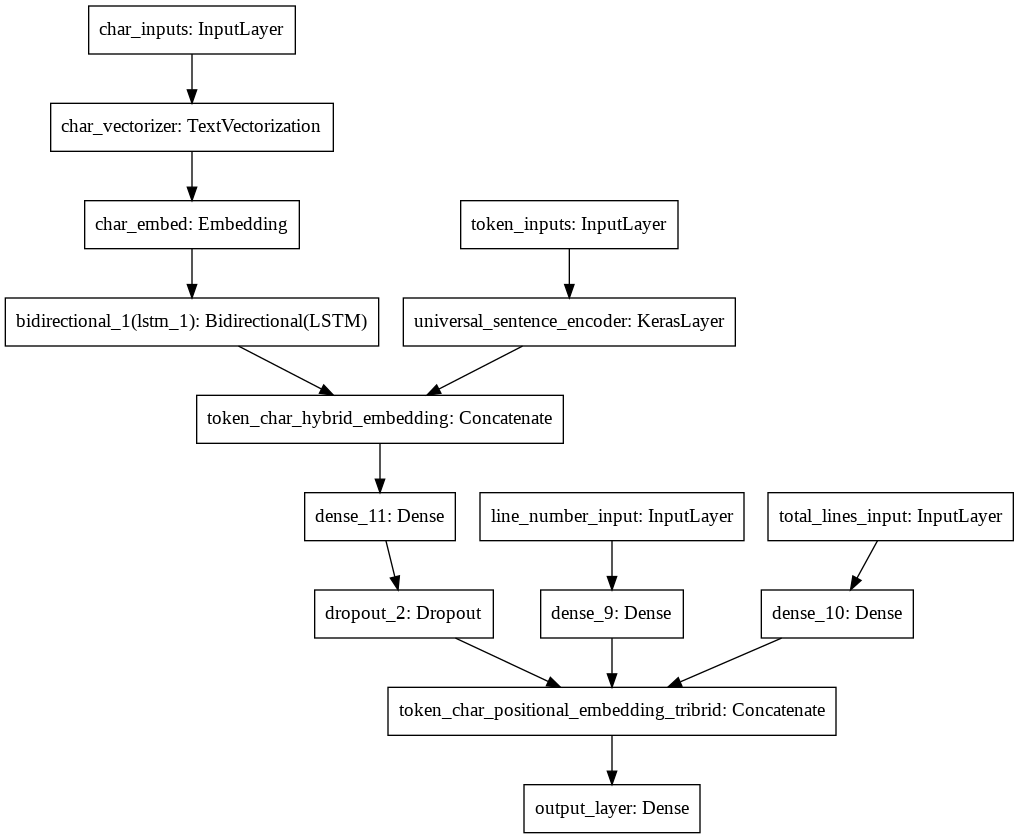

In [122]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [123]:
# Check which layers of our model are trainable or not
for num,layer in enumerate(model_5.layers):
  print(f"{num}: {layer}                    : {layer.trainable}")

0: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7c641c5750>                    : True
1: <tensorflow.python.keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f7bf00c3f10>                    : True
2: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7c6418b5d0>                    : True
3: <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f7bb6937150>                    : True
4: <tensorflow_hub.keras_layer.KerasLayer object at 0x7f7cb00b82d0>                    : False
5: <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f7c64103f50>                    : True
6: <tensorflow.python.keras.layers.merge.Concatenate object at 0x7f7b31639610>                    : True
7: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7c640ffc90>                    : True
8: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7b316eb250>                    : True
9: <

## Label_smoothing Important -> helps prevent overfitting

> A parameter to our loss function called label_smoothing. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:


* [0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).
It's predictions will get smoothed to be something like:

* [0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.

In [124]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Create tribrid embedding datasets and fit tribrid model

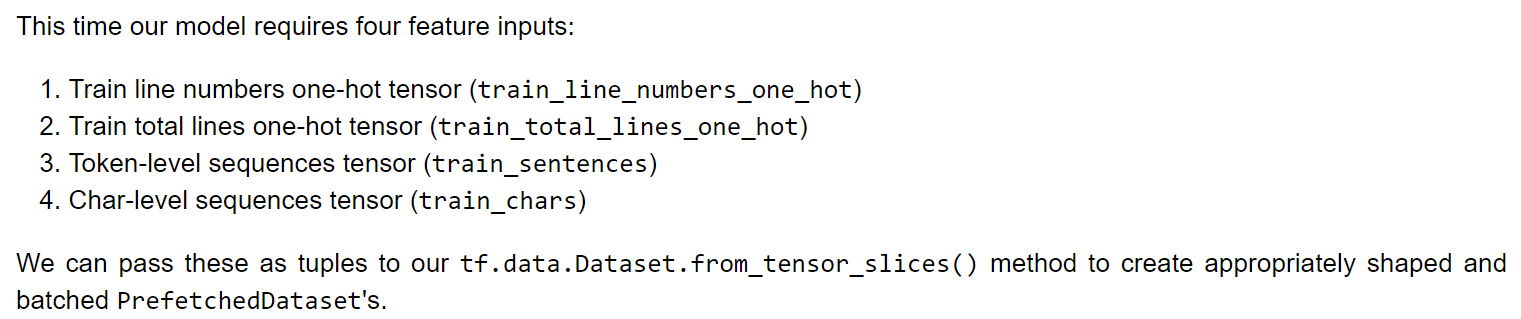

In [125]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data,val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [126]:

# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 36s 52ms/step - loss: 1.0918 - accuracy: 0.7313 - val_loss: 0.9854 - val_accuracy: 0.8025
Epoch 2/3
562/562 [==============================] - 26s 47ms/step - loss: 0.9770 - accuracy: 0.8109 - val_loss: 0.9582 - val_accuracy: 0.8215
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.9623 - accuracy: 0.8198 - val_loss: 0.9488 - val_accuracy: 0.8275


In [127]:

# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 23s 22ms/step


array([[0.5336499 , 0.1309898 , 0.01031637, 0.30712396, 0.01791994],
       [0.5541545 , 0.09948494, 0.04449294, 0.2919809 , 0.00988663],
       [0.25589487, 0.1295318 , 0.11798486, 0.42455515, 0.07203331],
       ...,
       [0.04183341, 0.10775641, 0.05363031, 0.03445627, 0.76232356],
       [0.02919443, 0.31466803, 0.07565067, 0.0236771 , 0.5568098 ],
       [0.15508309, 0.5433478 , 0.17538983, 0.03430038, 0.09187893]],
      dtype=float32)

In [128]:

# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [129]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.89090427644645,
 'f1': 0.827816738779832,
 'precision': 0.8271505981984578,
 'recall': 0.8289090427644644}

# Compare model results

In [141]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.707136,0.783915,0.787071,0.784693
pretrained_token_embed,73.619754,0.737311,0.736198,0.735476
custom_char_embed_conv1d,65.536873,0.655577,0.655369,0.647839
hybrid_char_token_embed,73.752151,0.737421,0.737522,0.736011
tribrid_pos_char_token_embed,82.890904,0.827151,0.828909,0.827817


In [142]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

TypeError: ignored

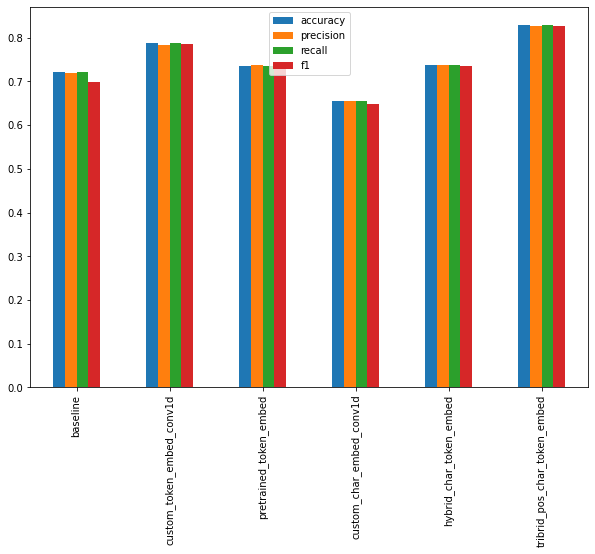

In [143]:
all_model_results.plot(kind = 'bar', figsize = (10,7)).legend(bboz_to_anchor = (1.0,1.0));
#place legend bos outside the plot

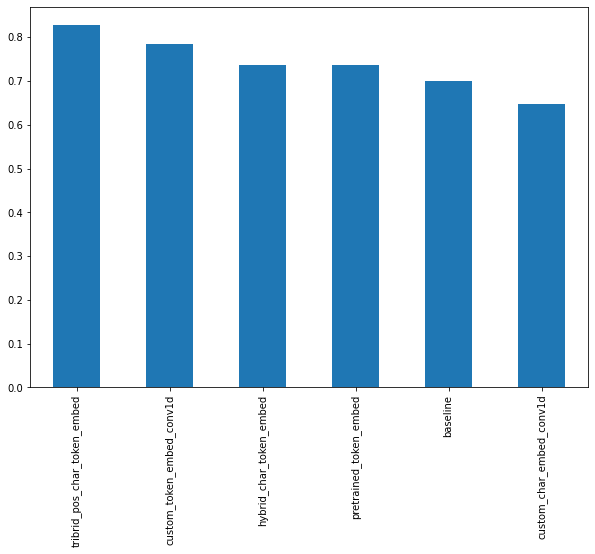

In [144]:
all_model_results.sort_values('f1',ascending = False)['f1'].plot(kind = 'bar', figsize = (10,7));


> In comparison to the results reported in Table 3 of the [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper](https://arxiv.org/pdf/1710.06071.pdf), our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).

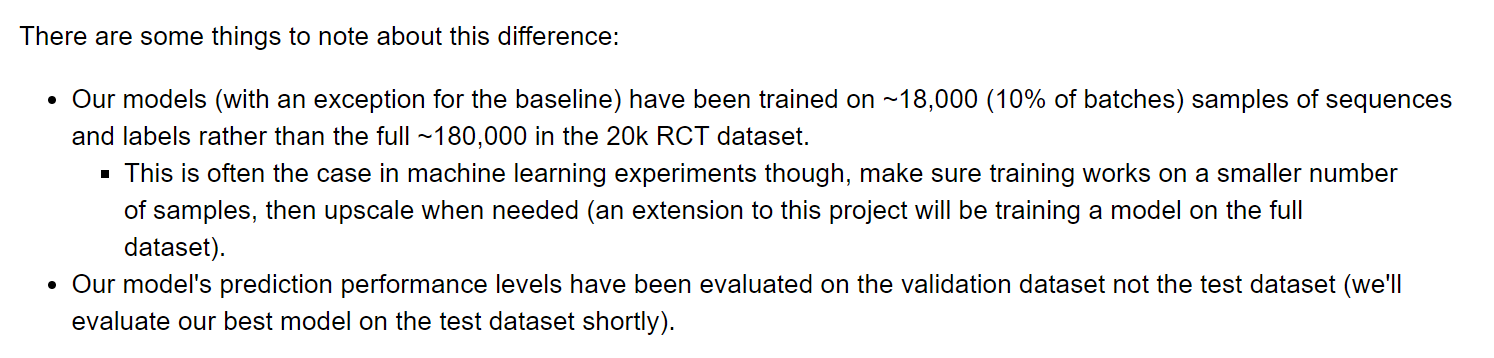

# Save and load best performing model

In [145]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [146]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [148]:
# Example of copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
!cp /content/skimlit_tribrid_model -r /content/drive/MyDrive/tensorflow/skimlit

# Evaluate Model on test set

In [157]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [159]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 21s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

In [160]:
# Evaluate loaded model test predictions
model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
model_test_results

{'accuracy': 82.24655715944914,
 'f1': 0.8213106460779728,
 'precision': 0.8207090134799317,
 'recall': 0.8224655715944914}

## Find most wrong

In [161]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 9.42 s, sys: 812 ms, total: 10.2 s
Wall time: 8.51 s


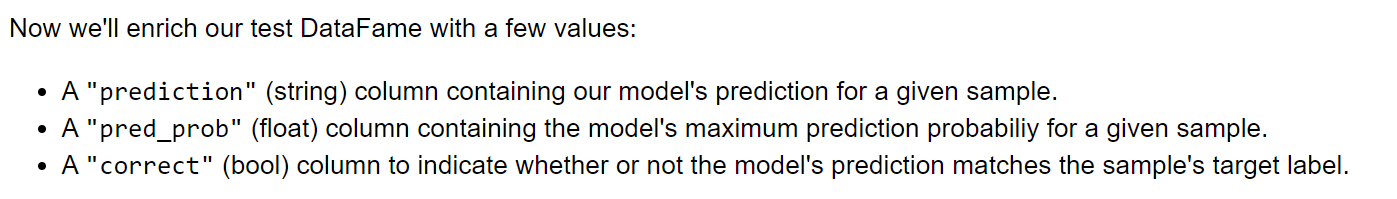

In [162]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.526757,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.333213,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.722554,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.669965,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.777767,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.890500,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.471284,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.484829,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.516275,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.546952,True


In [163]:

# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.947672,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.947492,False
1221,RESULTS,data were collected prospectively for @ months...,3,13,METHODS,0.926415,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.921320,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.919723,False
...,...,...,...,...,...,...,...
6665,METHODS,this study provides class i evidence that in p...,9,10,CONCLUSIONS,0.828446,False
19425,RESULTS,a decision-analytical model based on patient-l...,3,12,METHODS,0.827098,False
16840,RESULTS,the primary endpoint was a composite of cardio...,3,12,METHODS,0.826155,False
12575,BACKGROUND,the device was used to transmit weekly blood g...,3,11,METHODS,0.825778,False


In [164]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9476723670959473, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9474915862083435, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9264147877693176, Line number: 3, Total lines: 13

Text:
data were collected prospectively for @ months beginning after completion of the first @ group clinic appointments ( @ months post randomization ) .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9213199615478516, Line number: 6, Total lines: 9

Text:
-@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9197233319282532, Line number: 3, Total lines: 16

Text:
a cluster randomised trial was implem